# Transfer Learning for Skin Cancer Detection

Pre-build models that we will use are:
1. InceptionV3
2. DenseNet121
3. Simple fusion using weighted sum (where the sum of the weights = 1) from the two models

In [202]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

# Library for splitting and accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep learning library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.applications import InceptionV3, DenseNet121

# Get the model
InceptionV3 = InceptionV3(input_shape=(224,224,3), include_top=False)
DenseNet121 = DenseNet121(input_shape=(224,224,3), include_top=False)

In [174]:
# Build model function
def build_model(model, model_name):
    # Freezing the parameters of the pre-trained model 
    model.trainable = False
    # Creating the final model
    final_model = Sequential()
    # Adding the pre-trained model
    final_model.add(model)
    
    if model_name == 'InceptionV3':
        final_model.add(Flatten())
        final_model.add(Dense(128, activation='relu'))
        final_model.add(Dense(128, activation='relu'))
    else:
        # Adding convolutional layer
        final_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='custom_conv'))
        # Adding the GlobalAvgPool2D layer
        final_model.add(GlobalAvgPool2D())
        final_model.add(Dense(128, activation='relu'))
        final_model.add(Dense(128, activation='relu'))
    
    # Adding a Dense layer with 2 neurons and softmax activation
    final_model.add(Dense(2, activation='softmax'))
    # Printing the summary of the model
    final_model.summary()
    # Returning the final model
    return final_model

## Data Preparation

In [33]:
# Prepare a container for each of the image file and its label
df = {'filepath':[],'label':[]}

# Get the directory for the benign and malignant
data_dir = pathlib.Path('/kaggle/input/skin-cancer-isic-images')
train_benign_dir = data_dir / "benign"
train_malignant_dir = data_dir / "malignant"

# Create a generator to save all of the benign and malignant data
benign_images = train_benign_dir.glob('*.jpg')
malignant_images = train_malignant_dir.glob('*.jpg')

In [4]:
# Save all of the filepath and label of each image into the df container (variable)
for img in benign_images:
    df['filepath'].append(str(img))
    df['label'].append('Benign')
for img in malignant_images:
    df['filepath'].append(str(img))
    df['label'].append('Malignant')

In [5]:
# Convert the df variable (which is a dictionary) into a pandas data frame
df = pd.DataFrame.from_dict(df)

# Split the data into training and test set
train_df,test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

# Prepare normalization to 0-1
# Default batch size is 32
train_gen = ImageDataGenerator(rescale = 1.0/255)
test_gen = ImageDataGenerator(rescale = 1.0/255)
train_data = train_gen.flow_from_dataframe(train_df, x_col='filepath', y_col='label', target_size=(224,224))
test_data = train_gen.flow_from_dataframe(test_df, x_col='filepath', y_col='label', target_size=(224,224), shuffle=False)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


## Data Visualization

In [51]:
# Check sample data
sample_imgs, sample_labels = next(train_data)
classes = list(train_data.class_indices.keys())

# Check one of the image
found = [False, False]
for i, label in enumerate(sample_labels):
    if label[0] == 1 and not found[0]:
        found[0] = i
    elif label[1] == 1 and not found[1]:
        found[1] = i
    elif found[0] and found[1]:
        break

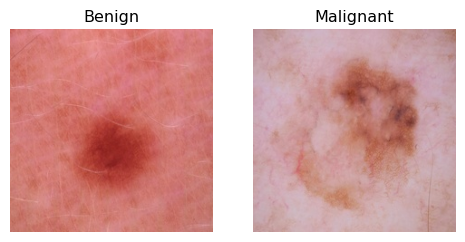

In [52]:
# Visualize the sample to check the image
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=96)
for cn,ind in enumerate(found):
    ax[cn].imshow(sample_imgs[ind])
    ax[cn].set_title(classes[cn],fontsize=12)
    ax[cn].set_axis_off()

## Model Training

### DenseNet121

In [175]:
# Create the model
final_DenseNet121_model = build_model(DenseNet121, 'DenseNet121')
final_DenseNet121_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv (Conv2D)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [176]:
# Fit the model
final_DenseNet121_model.fit(train_data, epochs=25, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)], validation_data=test_data, shuffle=False)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 339ms/step - accuracy: 0.7263 - loss: 0.5085 - val_accuracy: 0.8288 - val_loss: 0.3611
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8481 - loss: 0.3367 - val_accuracy: 0.8394 - val_loss: 0.3557
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8644 - loss: 0.3060 - val_accuracy: 0.8409 - val_loss: 0.3260
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8827 - loss: 0.2565 - val_accuracy: 0.8485 - val_loss: 0.3220
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8721 - loss: 0.2504 - val_accuracy: 0.8667 - val_loss: 0.3180
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8939 - loss: 0.2300 - val_accuracy: 0.8394 - val_loss: 0.4049
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8934 - loss: 0.2215 - val_accuracy: 0.8621 - val_loss: 0.3961
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9064 - loss: 0.2028 - val_accuracy: 0.8621 -

In [206]:
# Get the accuracy
pred = final_DenseNet121_model.predict(test_data)
preds = list(np.argmax(pred, axis=1))
diagnosis = [classes[n] for n in preds]
model_confusion_matrix = confusion_matrix(y_true=list(test_df['label']),y_pred=diagnosis)
print(f"The accuracy of the DenseNet121 model was {round(accuracy_score(diagnosis, list(test_df['label']))*100, 2)}.")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
The accuracy of the DenseNet121 model was 86.67.


In [207]:
print(classification_report(y_true=list(test_df['label']), y_pred=diagnosis))

              precision    recall  f1-score   support

      Benign       0.87      0.90      0.89       375
   Malignant       0.87      0.82      0.84       285

    accuracy                           0.87       660
   macro avg       0.87      0.86      0.86       660
weighted avg       0.87      0.87      0.87       660



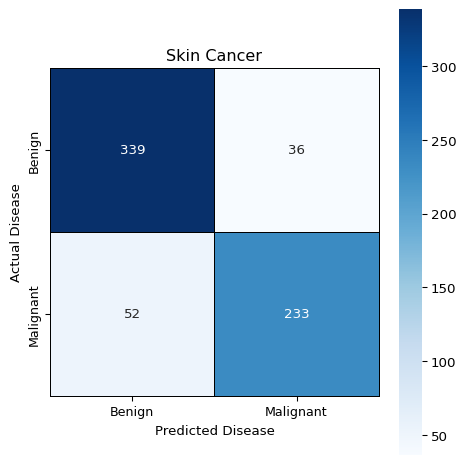

In [179]:
# Heatmap plot
plt.figure(figsize=(5,5),dpi=96)
sns.heatmap(model_confusion_matrix, annot=True, fmt='d', linewidths=0.5, linecolor='black', clip_on=False, square=True, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xticks(fontsize=9.5,rotation=0)
plt.yticks(fontsize=9.5,rotation=90)
plt.xlabel('Predicted Disease')
plt.ylabel('Actual Disease')
plt.title('Skin Cancer')
plt.tight_layout()
plt.show()

In [180]:
# Save the entire model to a file
# final_DenseNet121_model.save('/kaggle/working/DenseNet121_final_model.keras')
final_DenseNet121_model.save('/kaggle/working/DenseNet121_final_model2.keras')

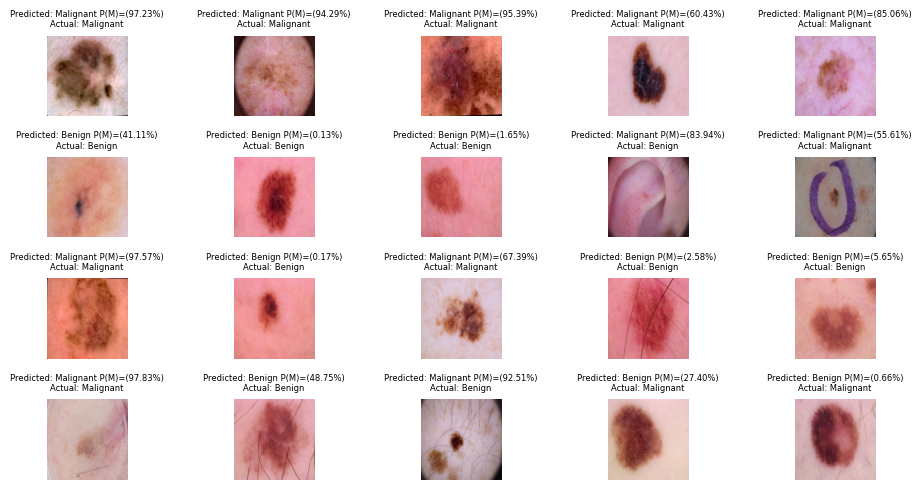

In [100]:
# Get the actual labels and file paths from the test data
actual_labels = test_data.labels
file_paths = test_data.filepaths

# Define class labels (update with your class labels)
class_labels = list(test_data.class_indices.keys())

# Loop through the first two images
plt.figure(figsize=(10, 5))  # Set up the figure for 2 images
j = 0
for i in range(20):  # Display the first two images
    # Load the image from the file path
    img = plt.imread(file_paths[i])

    # Get the actual label and predicted label
    actual_class = class_labels[actual_labels[i]]
    predicted_class = class_labels[preds[i]]
    predicted_prob = pred[i][1]

    # Plot the image
    plt.subplot(4, 5, j + 1)  # 1 row, 2 columns, current index
    j = j + 1
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    title = (
        f"Predicted: {predicted_class} P(M)=({predicted_prob*100:.2f}%)\n" # P(M) is the probability of Malignant
        f"Actual: {actual_class}"
    )
    plt.title(title, fontsize=6)

# Display the figure
plt.tight_layout()
plt.show()

### InceptionV3

In [181]:
# Create the model
final_InceptionV3_model = build_model(InceptionV3, 'InceptionV3')
final_InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [182]:
# Fit the model
final_InceptionV3_model.fit(train_data, epochs=25, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)], validation_data=test_data, shuffle=False)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.6617 - loss: 3.4793 - val_accuracy: 0.7742 - val_loss: 0.5166
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8454 - loss: 0.3813 - val_accuracy: 0.7848 - val_loss: 0.6104
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8694 - loss: 0.3078 - val_accuracy: 0.8439 - val_loss: 0.4346
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9446 - loss: 0.1424 - val_accuracy: 0.8439 - val_loss: 0.4855
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9688 - loss: 0.0869 - val_accuracy: 0.8303 - val_loss: 0.5373
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9870 - loss: 0.0490 - val_accuracy: 0.8424 - val_loss: 0.5814
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9933 - loss: 0.0243 - val_accuracy: 0.8258 - val_loss: 0.5958
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9984 - loss: 0.0173 - val_accuracy: 0.7955 -

83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step
The accuracy of the InceptionV3 model was 49.68.


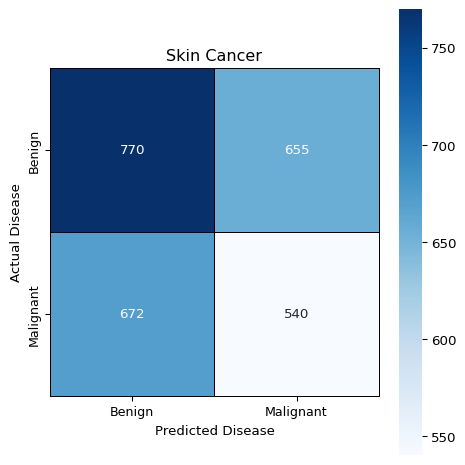

In [183]:
# Get the accuracy
pred = final_InceptionV3_model.predict(train_data)
preds = list(np.argmax(pred, axis=1))
diagnosis = [classes[n] for n in preds]
model_confusion_matrix = confusion_matrix(y_true=list(train_df['label']),y_pred=diagnosis)
print(f"The accuracy of the InceptionV3 model was {round(accuracy_score(diagnosis, list(train_df['label']))*100, 2)}.")

# Heatmap plot
plt.figure(figsize=(5,5),dpi=96)
sns.heatmap(model_confusion_matrix, annot=True, fmt='d', linewidths=0.5, linecolor='black', clip_on=False, square=True, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xticks(fontsize=9.5,rotation=0)
plt.yticks(fontsize=9.5,rotation=90)
plt.xlabel('Predicted Disease')
plt.ylabel('Actual Disease')
plt.title('Skin Cancer')
plt.tight_layout()
plt.show()

In [204]:
# Get the accuracy
pred = final_InceptionV3_model.predict(test_data)
preds = list(np.argmax(pred, axis=1))
diagnosis = [classes[n] for n in preds]
model_confusion_matrix = confusion_matrix(y_true=list(test_df['label']),y_pred=diagnosis)
print(f"The accuracy of the DenseNet121 model was {round(accuracy_score(diagnosis, list(test_df['label']))*100, 2)}.")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
The accuracy of the DenseNet121 model was 84.39.


In [205]:
print(classification_report(y_true=list(test_df['label']), y_pred=diagnosis))

              precision    recall  f1-score   support

      Benign       0.85      0.88      0.87       375
   Malignant       0.84      0.79      0.81       285

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



In [185]:
# Save the entire model to a file
# final_InceptionV3_model.save('/kaggle/working/InceptionV3_final_model.keras')
final_InceptionV3_model.save('/kaggle/working/InceptionV3_final_model2.keras')

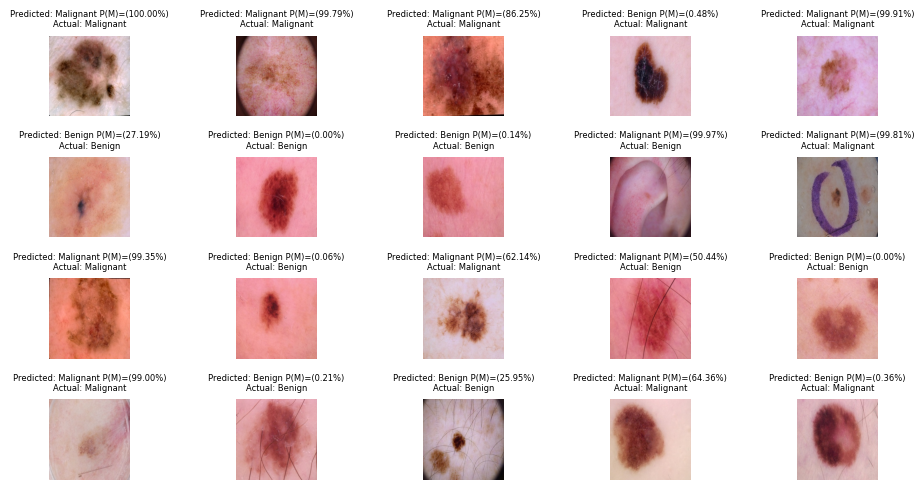

In [102]:
# Get the actual labels and file paths from the test data
actual_labels = test_data.labels
file_paths = test_data.filepaths

# Define class labels (update with your class labels)
class_labels = list(test_data.class_indices.keys())

# Loop through the first two images
plt.figure(figsize=(10, 5))  # Set up the figure for 2 images
j = 0
for i in range(20):  # Display the first two images
    # Load the image from the file path
    img = plt.imread(file_paths[i])

    # Get the actual label and predicted label
    actual_class = class_labels[actual_labels[i]]
    predicted_class = class_labels[preds[i]]
    predicted_prob = pred[i][1]

    # Plot the image
    plt.subplot(4, 5, j + 1)  # 1 row, 2 columns, current index
    j = j + 1
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    title = (
        f"Predicted: {predicted_class} P(M)=({predicted_prob*100:.2f}%)\n" # P(M) is the probability of Malignant
        f"Actual: {actual_class}"
    )
    plt.title(title, fontsize=6)

# Display the figure
plt.tight_layout()
plt.show()

### Fusion

In [192]:
# Label from training data
label_train = test_data.labels

# Predicted train from DenseNet121
# densenetmodel = tf.keras.models.load_model('/kaggle/working/DenseNet121_final_model.keras')
# pred_densenet = densenetmodel.predict(test_data)
pred_densenet = final_DenseNet121_model.predict(test_data)
pred_densenet = pred_densenet[:, 1]

# Predicted train from InceptionV3
# incmodel = tf.keras.models.load_model('/kaggle/working/InceptionV3_final_model.keras')
# pred_incv3 = incmodel.predict(test_data)
pred_incv3 = final_InceptionV3_model.predict(test_data)
pred_incv3 = pred_incv3[:, 1]

# Get the data for linear model
df_linmod = pd.DataFrame({
    'dense': pred_densenet,
    'inc': pred_incv3,
    'label': label_train
})
df_linmod.head()

# Get the logistic regression
X = df_linmod.drop('label', axis=1)
y = df_linmod['label']

# Result
result = []
for i in np.linspace(0, 1, 21):
    result.append((i*X['dense'].to_numpy()) + ((1-i)*X['inc'].to_numpy()))
result = np.array(result)

# Map values: > 0.5 becomes 1, otherwise 0
mapped_array = (result > 0.5).astype(int)

for i, j in enumerate(np.linspace(0, 1, 21)):
    print(f'wDense={j} & wIncV3={1-j}')
    print(f'accuracy={round(accuracy_score(mapped_array[i], y)*100, 2)}\n')

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
wDense=0.0 & wIncV3=1.0
accuracy=84.39

wDense=0.05 & wIncV3=0.95
accuracy=84.55

wDense=0.1 & wIncV3=0.9
accuracy=84.7

wDense=0.15000000000000002 & wIncV3=0.85
accuracy=84.7

wDense=0.2 & wIncV3=0.8
accuracy=84.85

wDense=0.25 & wIncV3=0.75
accuracy=85.3

wDense=0.30000000000000004 & wIncV3=0.7
accuracy=85.45

wDense=0.35000000000000003 & wIncV3=0.6499999999999999
accuracy=85.61

wDense=0.4 & wIncV3=0.6
accuracy=85.91

wDense=0.45 & wIncV3=0.55
accuracy=86.21

wDense=0.5 & wIncV3=0.5
accuracy=86.82

wDense=0.55 & wIncV3=0.44999999999999996
accuracy=86.97

wDense=0.6000000000000001 & wIncV3=0.3999999999999999
accuracy=86.97

wDense=0.65 & wIncV3=0.35
accuracy=87.27

wDense=0.7000000000000001 & wIncV3=0.29999999999999993
accuracy=86.97

wDense=0.75 & wIncV3=0.25
accuracy=87.58

wDense=0.8 & wIncV3=0.19999999999999996
accuracy=87.73

wDense=0.8500000000000001 & wIncV3=0.1499999999999999
accuracy=87.88

wDens

The best fusion of the sum rule achieved an accuracy of 87.88% from the test data with each weights is wDense=0.8500000000000001 & wIncV3=0.1499999999999999.

The second best model achieved 87.73% with weights wDense=0.7000000000000001 & wIncV3=0.29999999999999993.

In [198]:
# Predicted probability from the weights
wDense=0.8500000000000001
wIncV3=0.1499999999999999
predicted_prob_all = (wDense*pred_densenet) + (wIncV3*pred_incv3)
predicted_class_all = (predicted_prob_all > 0.5).astype(int)

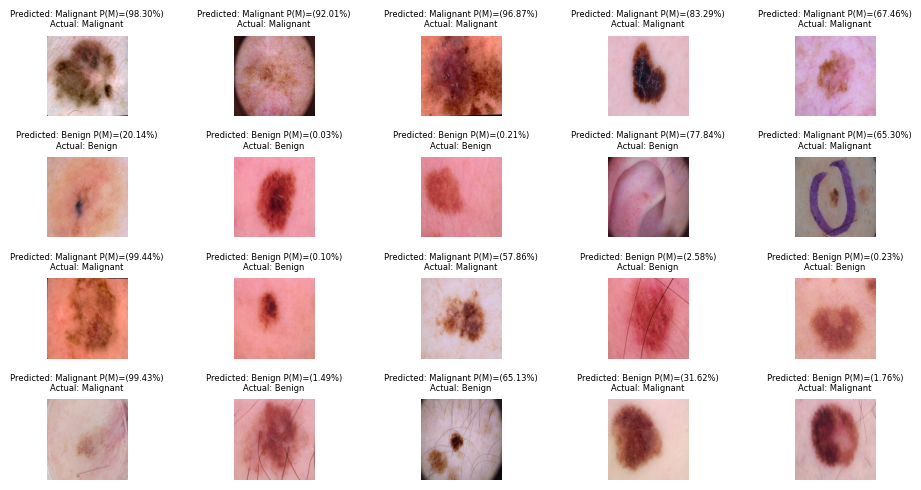

In [200]:
# Get the actual labels and file paths from the test data
actual_labels = test_data.labels
file_paths = test_data.filepaths

# Define class labels (update with your class labels)
class_labels = list(test_data.class_indices.keys())

# Loop through the first two images
plt.figure(figsize=(10, 5))  # Set up the figure for 2 images
j = 0
for i in range(20):  # Display the first two images
    # Load the image from the file path
    img = plt.imread(file_paths[i])

    # Get the actual label and predicted label
    actual_class = class_labels[actual_labels[i]]
    predicted_class = class_labels[predicted_class_all[i]]
    predicted_prob = predicted_prob_all[i]

    # Plot the image
    plt.subplot(4, 5, j + 1)  # 1 row, 2 columns, current index
    j = j + 1
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    title = (
        f"Predicted: {predicted_class} P(M)=({predicted_prob*100:.2f}%)\n" # P(M) is the probability of Malignant
        f"Actual: {actual_class}"
    )
    plt.title(title, fontsize=6)

# Display the figure
plt.tight_layout()
plt.show()

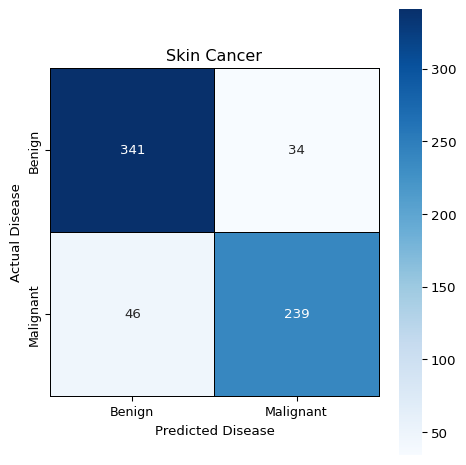

In [201]:
# Heatmap plot
model_confusion_matrix = confusion_matrix(y_true=actual_labels, y_pred=predicted_class_all)

plt.figure(figsize=(5,5),dpi=96)
sns.heatmap(model_confusion_matrix, annot=True, fmt='d', linewidths=0.5, linecolor='black', clip_on=False, square=True, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xticks(fontsize=9.5,rotation=0)
plt.yticks(fontsize=9.5,rotation=90)
plt.xlabel('Predicted Disease')
plt.ylabel('Actual Disease')
plt.title('Skin Cancer')
plt.tight_layout()
plt.show()

In [203]:
print(classification_report(y_true=actual_labels, y_pred=predicted_class_all))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       375
           1       0.88      0.84      0.86       285

    accuracy                           0.88       660
   macro avg       0.88      0.87      0.88       660
weighted avg       0.88      0.88      0.88       660

